1. Importing Libraries


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [3]:
review_path = "output_file/*.parquet"
parquet_files_review = glob.glob(review_path)
# Read all the Parquet files and concatenate them into a single DataFrame
df2 = pd.concat([pd.read_parquet(file) for file in parquet_files_review])

In [4]:
restaurants_reviews = df2

2. Text Cleaning


In [5]:
def clean_text(text):
    text = text.str.lower().str.replace('\n', '')
    text = text.str.replace(r'[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', '', regex=True)
    return text


3. Loading Positive and Negative Words


In [6]:
def load_words(filename):
    with open(filename, 'r') as file:
        return [line.strip() for line in file]

positive_words = load_words('positive.txt')
negative_words = load_words('negative.txt')


4. Filtering Words in Reviews


In [7]:
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    return ' '.join(words)


5. Getting Dataset by Category


In [8]:
def get_dataset(category):
    df = restaurants_reviews[restaurants_reviews['category'] == category].copy()
    df['text'] = clean_text(df['text'])
    df['text'] = df['text'].apply(filter_words)
    return df[['text', 'labels']]


6. Calculating Polarity Scores


In [9]:
def get_polarity_score(dataset):
    terms_train, class_train = dataset['text'], dataset['labels']
    
    vectorizer = CountVectorizer()
    feature_train_counts = vectorizer.fit_transform(terms_train)
    
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names_out()})
    
    # Reset index to avoid duplicate index errors
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names_out()).reset_index(drop=True)
    class_train = class_train.reset_index(drop=True)
    
    # Adding 'labels' to cuisine_reviews DataFrame
    cuisine_reviews['labels'] = class_train
    
    # Calculate the frequency of each word
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] == 'positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    cuisine_polarity_score['polarity'] = (cuisine_polarity_score['score'] * cuisine_polarity_score['frequency']) / len(dataset)
    
    # Handling potentially unuseful words
    unuseful_words = ['great', 'amazing', 'love', 'best', 'awesome', 'excellent', 'good',
                      'favorite', 'loved', 'perfect', 'gem', 'perfectly', 'wonderful',
                      'happy', 'enjoyed', 'nice', 'well', 'super', 'like', 'better', 'decent', 
                      'fine', 'pretty', 'enough', 'excited', 'impressed', 'ready', 
                      'fantastic', 'glad', 'right', 'fabulous', 'bad', 'disappointed', 
                      'unfortunately', 'disappointing', 'horrible', 'lacking', 'terrible', 'sorry']

    cuisine_polarity_score.drop(unuseful_words, axis=0, errors='ignore', inplace=True)
    
    return cuisine_polarity_score


7. Plotting Top Words


In [10]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11, 6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title(f'TOP 10 Positive and Negative Words in {category} Restaurants', fontsize=15)
    plt.xticks(rotation=15)
    plt.show()


8. Getting Top Words


In [11]:
def get_top_words(dataset, label, number=10):
    if label == 'positive':
        return dataset[dataset.polarity > 0].sort_values('polarity', ascending=False)[:number]
    else:
        return dataset[dataset.polarity < 0].sort_values('polarity')[:number]


9. Printing Polarity Score Table


In [12]:
def print_polarity_table(polarity_score, category):
    print(f"Polarity Score Table for {category} Restaurants")
    print(polarity_score[['score', 'frequency', 'polarity']].sort_values(by='polarity', ascending=False))
    print("\n")


10. Processing All Categories


Polarity Score Table for Korean Restaurants
            score frequency polarity
word                                
delicious  0.4562       731   0.0475
fresh      0.3872       723   0.0399
friendly   0.2929       654   0.0273
recommend  0.1926       671   0.0184
fried      0.0937      1060   0.0142
...           ...       ...      ...
sad       -0.6855        34  -0.0033
bland     -0.8595        28  -0.0034
wrong     -0.3259        79  -0.0037
cold      -0.1882       161  -0.0043
hard      -0.2501       174  -0.0062

[1815 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


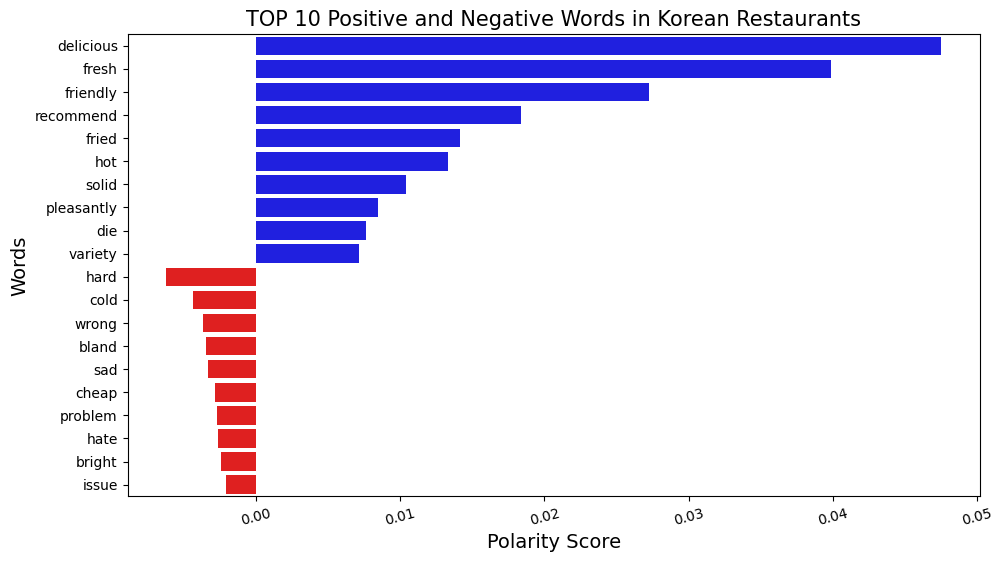

Polarity Score Table for Japanese Restaurants
            score frequency polarity
word                                
delicious  0.4880      2160   0.0405
fresh      0.2762      3486   0.0370
friendly   0.3427      2124   0.0280
recommend  0.1727      2300   0.0153
sweet      0.2482       868   0.0083
...           ...       ...      ...
bland     -0.8152        80  -0.0025
warm      -0.2215       304  -0.0026
expensive -0.3109       280  -0.0033
slow      -0.3691       260  -0.0037
cold      -0.2620       371  -0.0037

[2857 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


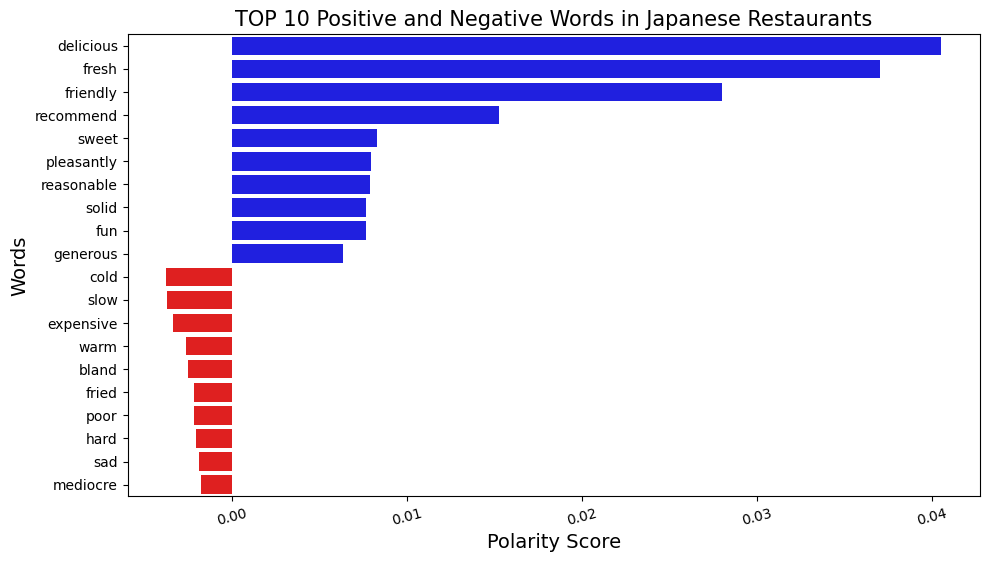

Polarity Score Table for Thai Restaurants
            score frequency polarity
word                                
delicious  0.5517      1752   0.0585
friendly   0.3435      1527   0.0318
fresh      0.2474      1794   0.0269
recommend  0.1934      1496   0.0175
hot        0.1744      1104   0.0117
...           ...       ...      ...
expensive -0.3925       114  -0.0027
top       -0.1052       438  -0.0028
slow      -0.3094       159  -0.0030
bland     -0.9166        62  -0.0034
cold      -0.4610       156  -0.0044

[2305 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


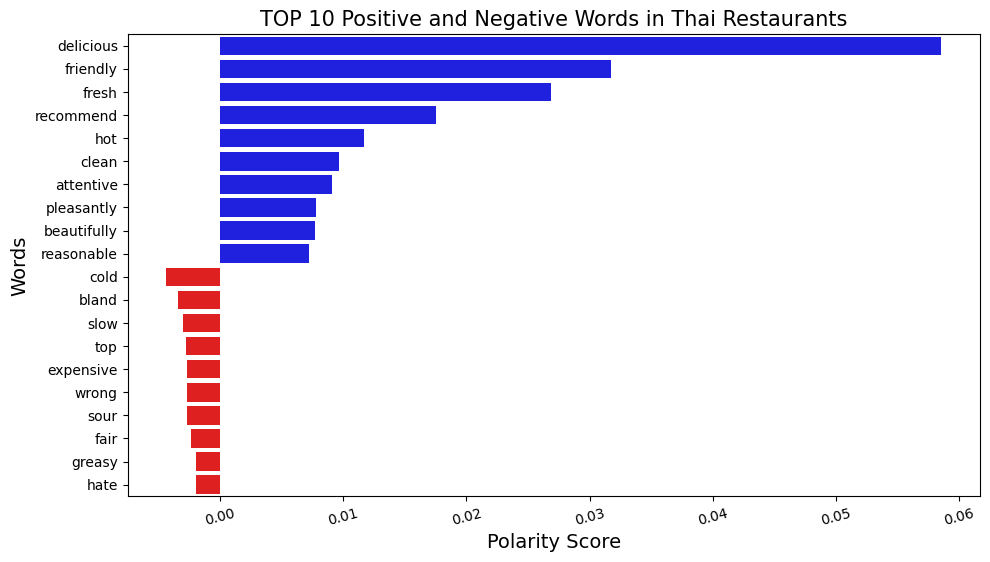

Polarity Score Table for Chinese Restaurants
            score frequency polarity
word                                
delicious  0.5584      2909   0.0428
fresh      0.3264      3360   0.0289
friendly   0.3235      2530   0.0216
recommend  0.2246      2848   0.0169
authentic  0.2687      1715   0.0121
...           ...       ...      ...
wrong     -0.2566       420  -0.0028
bland     -0.6643       181  -0.0032
hard      -0.1600       755  -0.0032
cold      -0.2745       627  -0.0045
sour      -0.1075      1717  -0.0049

[3179 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


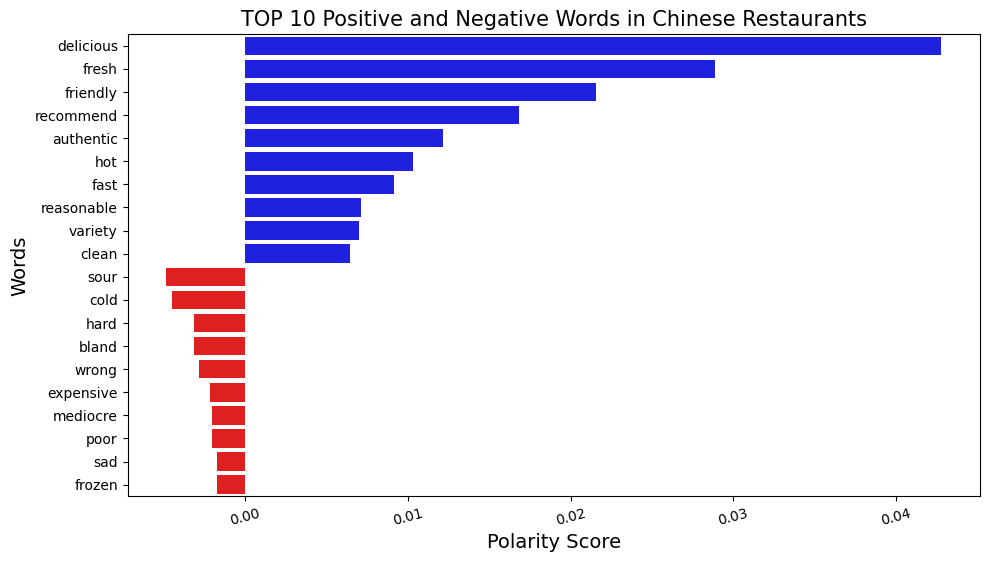

Polarity Score Table for Vietnamese Restaurants
            score frequency polarity
word                                
delicious  0.6010      1306   0.0681
fresh      0.2066      1657   0.0297
friendly   0.3049      1078   0.0285
recommend  0.2602       896   0.0202
fast       0.4443       400   0.0154
...           ...       ...      ...
wrong     -0.1962       148  -0.0025
slow      -0.3801        81  -0.0027
lack      -0.5800        55  -0.0028
bland     -0.8878        43  -0.0033
hard      -0.1846       272  -0.0044

[2108 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


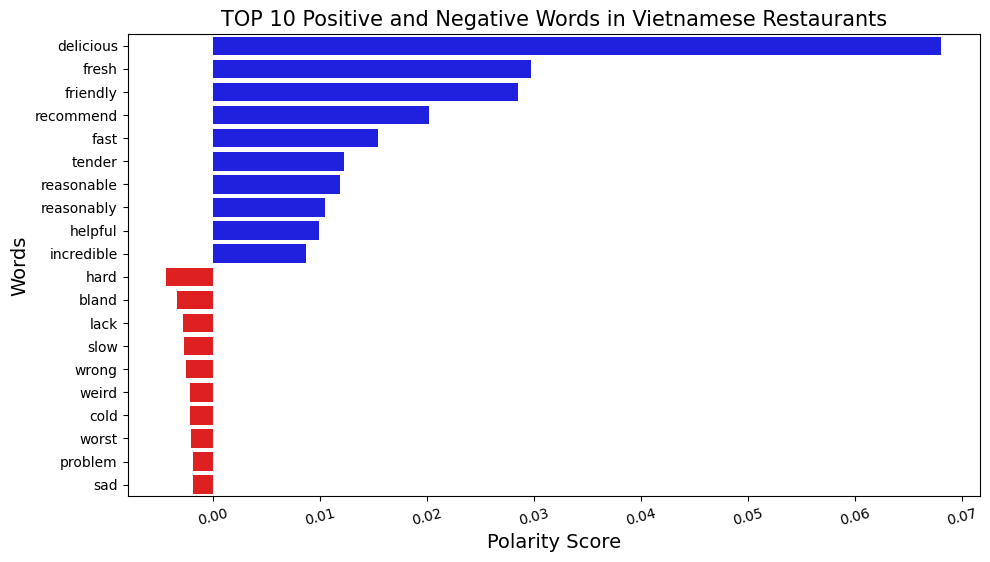

Polarity Score Table for French Restaurants
            score frequency polarity
word                                
delicious  0.3700       857   0.0475
fresh      0.2859       535   0.0229
die        0.9916       153   0.0227
recommend  0.2252       581   0.0196
fried      0.3355       390   0.0196
...           ...       ...      ...
poor      -0.8413        27  -0.0034
dark      -0.4687        49  -0.0034
slow      -0.4977        56  -0.0042
wrong     -0.3316       110  -0.0055
cold      -0.7057        79  -0.0084

[2159 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


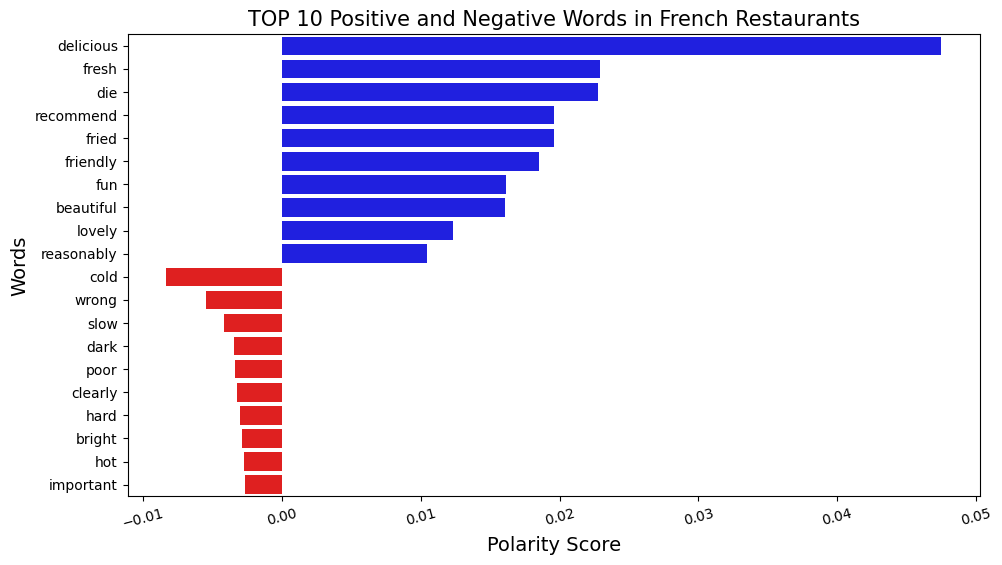

Polarity Score Table for Italian Restaurants
            score frequency polarity
word                                
delicious  0.4853      7329   0.0463
friendly   0.3089      6258   0.0252
fresh      0.2532      7060   0.0233
recommend  0.2422      5860   0.0185
die        0.6722      1325   0.0116
...           ...       ...      ...
bland     -0.7992       195  -0.0020
slow      -0.3910       455  -0.0023
wrong     -0.2356       982  -0.0030
hard      -0.2015      1624  -0.0043
cold      -0.4854       747  -0.0047

[3856 rows x 3 columns]




C:\Users\harsh\AppData\Local\Temp\ipykernel_16924\581613744.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_words.index, x=top_words.values, palette=colors)


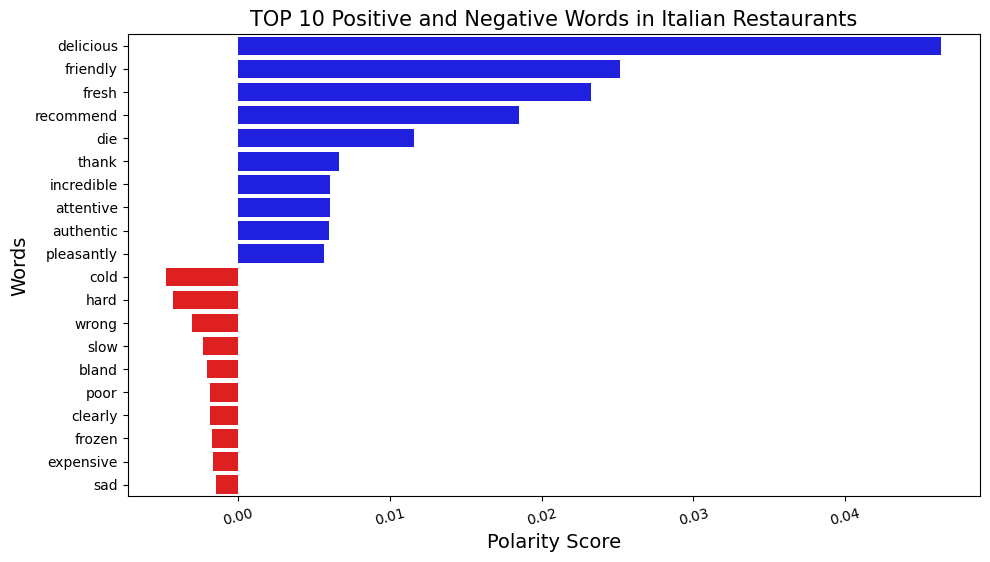

In [13]:
categories = ['Korean', 'Japanese', 'Thai', 'Chinese', 'Vietnamese', 'French', 'Italian']

for category in categories:
    reviews = get_dataset(category)
    train_data, _ = train_test_split(reviews, test_size=0.8)
    polarity_score = get_polarity_score(train_data)
     # Print polarity score table
    print_polarity_table(polarity_score, category)
    top_positive = get_top_words(polarity_score, 'positive')
    top_negative = get_top_words(polarity_score, 'negative')
    top_words = pd.concat([top_positive, top_negative])
    
    plot_top_words(top_words['polarity'], category)
